### IDENTIFICACIÓN DE COMERCIOS PARA PLAN DE MANTENIMIENTO INTELIGENTE EN RED DE DATÁFONOS
#### PROYECTO APRENDIZAJE NO SUPERVISADO
#### MAESTRIA INTELIGENCIA ANALITICA DE DATOS - UNIANDES

**EQUIPO:** 
- Laura Karina Rodríguez Arciniegas
- Jesica Andrea Vique Orjuela 
- Christian Ali Saker Barrera
- Brayan Stieven Torres Ovalle

In [1]:
#Librerias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster
from scipy.spatial.distance import pdist
import scipy.stats as stats

import os

In [2]:
#Lectura de los datos

#Ruta de tu archivo Excel
archivo_excel = 'C:/Users/Laura/Documents/MAESTRIA EN INTELIGENCIA ANALITICA DE DATOS/3.1 APRENDIZAJE NO SUPERVISADO/PROYECTO/tabla_final (Sin info comercio).xlsx'

#Función read_excel para leer el archivo Excel
df = pd.read_excel(archivo_excel, sheet_name='tabla_final')

df.head()

,ID,SECCIONAL_OPERACIONES,TERMINALES_VIGENTES,QR_ULT_MES,TRX_MES_ANT,TRX_ULT_MES,REVERSOS_ULT_MES,TASA_REVERSOS_ULT_MES,TASA_APROBACIONES_ULT _MES,TASA_NEGACIONES_ULT_MES,DIFERENCIA_TRX,VARIACION_TRX,TASA_QR
0,17033531,BOGOTA,1,0,0,0,0,0.000000,0.000000,1.000000,0,0.000000,0.0
1,19772482,BUCARAMANGA,4,0,990,1076,5,0.004647,0.959108,0.040892,86,0.086869,0.0
2,17207432,SANTA MARTA,2,2,0,6,1,0.166667,0.833333,0.166667,6,0.000000,1.0
3,18947663,MEDELLIN,1,0,129,153,1,0.006536,0.973856,0.026144,24,0.186047,0.0
4,14126726,MEDELLIN,2,0,92,75,0,0.000000,0.920000,0.080000,-17,-0.184783,0.0


In [3]:
# Obtener el tamaño del DataFrame
num_filas, num_columnas = df.shape
print(f'Número de filas: {num_filas}')
print(f'Número de columnas: {num_columnas}')

Número de filas: 135954
Número de columnas: 13


In [4]:
df.dtypes

ID                              int64
SECCIONAL_OPERACIONES          object
TERMINALES_VIGENTES             int64
QR_ULT_MES                      int64
TRX_MES_ANT                     int64
TRX_ULT_MES                     int64
REVERSOS_ULT_MES                int64
TASA_REVERSOS_ULT_MES         float64
TASA_APROBACIONES_ULT _MES    float64
TASA_NEGACIONES_ULT_MES       float64
DIFERENCIA_TRX                  int64
VARIACION_TRX                 float64
TASA_QR                       float64
dtype: object

In [5]:
# Verificar si hay valores nulos o vacíos en cada columna
valores_nulos_o_vacios = df.fillna('').eq('').sum()

# Mostrar el recuento de valores nulos o vacíos por columna
print(valores_nulos_o_vacios)

ID                            0
SECCIONAL_OPERACIONES         0
TERMINALES_VIGENTES           0
QR_ULT_MES                    0
TRX_MES_ANT                   0
TRX_ULT_MES                   0
REVERSOS_ULT_MES              0
TASA_REVERSOS_ULT_MES         0
TASA_APROBACIONES_ULT _MES    0
TASA_NEGACIONES_ULT_MES       0
DIFERENCIA_TRX                0
VARIACION_TRX                 0
TASA_QR                       0
dtype: int64


No existen datos nulos en el dataframe, por lo cual no es necesario la aplicación de técnicas para su tratamiento. 

**Descripción de las variables disponibles, de acuerdo al contexto del negocio:**

- **ID**: Código único o identificador de cada comercio. Corresponde a un punto físico o establecimiento comercial.
- **SECCIONAL_OPERACIONES:** Seccional a la que pertenece el comercio para su gestión operativa, según su ubicación geográfica. 
- **TERMINALES_VIGENTES:** Terminales con las que actualmente cuenta el comercio (Datáfonos).
- **QR_ULT_MES:** Quejas o Reclamos radicados por el comercio durante el último mes.
- **TRX_ULT_MES:** Transacciones realizadas por el comercio durante el último mes.
- **TRX_MES_ANT:** Transacciones realizadas por el comercio durante el mes inmediatamente anterior.
- **REVERSOS_ULT_MES:** Transacciones del comercio que fueron reversadas durante el último mes. 
- **TASA_REVERSOS_ULT_MES:** % transacciones reversadas respecto al total de transacciones realizadas por el comercio el último mes, esto es: REVERSOS_ULT_MES / TRX_ULT_MES
- **TASA_APROBACIONES_ULT_MES:** % Transacciones aprobadas respecto al total de transacciones realizadas por el comercio durante el último mes.
- **TASA_NEGACIONES_ULT_MES:** % Transacciones negadas respecto al total de transacciones realizadas por el comercio durante el último mes.
- **DIFERENCIA_TRX:** Diferencia entre las trx realizadas por el comercio en los últimos 2 meses, esto es: TRX_ULT_MES - TRX_MES_ANT.
- **VARIACION_TRX:** Variación (%)  del número de transacciones realizadas en los últimos 2 meses, esto es: (TRX_ULT_MES / TRX_MES_ANT) - 1
- **TASA_QR:** Tasa de quejas y reclamos por comercio según su número de terminales. Esto es: QR_ULT_MES / TERMINALES_VIGENTES.

In [6]:
# Calcular el número de registros con trx=0 según 'TRX_ULT_MES'
conteo_trx_cero = (df['TRX_ULT_MES'] == 0).sum()

# Calcular el porcentaje en relación con el total de registros
total_registros = len(df)
porcentaje_trx_cero = (conteo_trx_cero / total_registros) * 100

print(f'Número de registros con TRX_ULT_MES igual a 0: {conteo_trx_cero}')
print(f'Porcentaje de registros con TRX_ULT_MES igual a 0: {porcentaje_trx_cero:.2f}%')

Número de registros con TRX_ULT_MES igual a 0: 52017
Porcentaje de registros con TRX_ULT_MES igual a 0: 38.26%


In [7]:
# Filtrar el DataFrame para registros (comercios) con trx > 0
df = df.loc[df['TRX_ULT_MES'] > 0]

# Obtener el tamaño del DataFrame
num_filas, num_columnas = df.shape
print(f'Número de filas: {num_filas}')
print(f'Número de columnas: {num_columnas}')

Número de filas: 83937
Número de columnas: 13


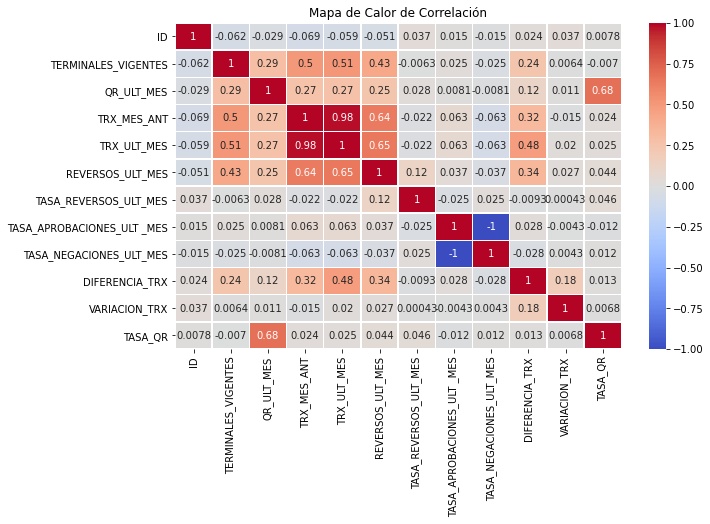

In [8]:
# Calcular la matriz de correlación
correlacion = df.corr()

# Crear un mapa de calor
plt.figure(figsize=(10, 6))  # Tamaño de la figura
sns.heatmap(correlacion, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlación')
plt.show()

**Depuración variables según correlación**:

TASA_NEGACIONES_ULT_MES = 1-TASA_APROBACIONES_ULT_MES. Por lo cual su correlación es = -100%.

- Se remueve la variable "TASA_APROBACIONES_ULT_MES" para evitar redundancia en los datos.
- Se conserva la variable "TASA_NEGACIONES_ULT_MES".

El numero de Trx del mes anterior tiene alta correlación con el número de Trx del último mes: 98%:

- Se remueve las variable "TRX_MES_ANT" para evitar redundancia en los datos.
- Se conserva la variable "TRX_ULT_MES".

Las siguientes variables, presentan correlaciones entre 64%-68%, se dejarán para el análisis y sujeto a los resultados se definirá si se mantienen:

- "QR_ULT_MES" y "TASA_QR" tienen correlación de 68%, dado que la TASA_QR = QR_ULT_MES / TERMINALES_VIGENTES
- "REVERSOS_ULT_MES" tienen correlación de 65% y 64% respecto a "TRX_ULT_MES" y "TRX_MES_ANT" respectivamente. Se esperaría que a mayor número de trx exista mayor número de reversos.

In [9]:
# Eliminar columnas específicas por nombre
columnas_a_eliminar = ['TASA_APROBACIONES_ULT _MES', 'TRX_MES_ANT']
df = df.drop(columnas_a_eliminar, axis=1)
df.columns

Index(['ID', 'SECCIONAL_OPERACIONES', 'TERMINALES_VIGENTES', 'QR_ULT_MES',
       'TRX_ULT_MES', 'REVERSOS_ULT_MES', 'TASA_REVERSOS_ULT_MES',
       'TASA_NEGACIONES_ULT_MES', 'DIFERENCIA_TRX', 'VARIACION_TRX',
       'TASA_QR'],
      dtype='object')

In [10]:
# Obtener el tamaño del DataFrame
num_filas, num_columnas = df.shape
print(f'Número de filas: {num_filas}')
print(f'Número de columnas: {num_columnas}')

Número de filas: 83937
Número de columnas: 11


In [11]:
#VARIABLES CATEGÓRICAS

# Contar la cantidad de seccionales diferentes
cantidad_seccionales = len(df['SECCIONAL_OPERACIONES'].unique())
print(f'Número de seccionales diferentes: {cantidad_seccionales}')

# Contar la cantidad de registros por SECCIONAL_OPERACIONES
conteo = df['SECCIONAL_OPERACIONES'].value_counts()

# Calcular los porcentajes
porcentajes = df['SECCIONAL_OPERACIONES'].value_counts(normalize=True) * 100

# Crear una tabla de resumen
tabla_resumen = pd.DataFrame({'Cantidad': conteo, 'Porcentaje (%)': porcentajes})

# Mostrar la tabla
print(tabla_resumen)

Número de seccionales diferentes: 23
                 Cantidad  Porcentaje (%)
BOGOTA              25092       29.893849
MEDELLIN            12150       14.475142
CALI                 8923       10.630592
BARRANQUILLA         4883        5.817458
BUCARAMANGA          4292        5.113359
CARTAGENA            2747        3.272693
CUCUTA               2655        3.163087
TUNJA                2236        2.663903
PEREIRA              2219        2.643649
PASTO                2135        2.543574
NEIVA                2020        2.406567
VILLAICENCIO         1972        2.349381
IBAGUE               1937        2.307683
SANTA MARTA          1906        2.270751
MONTERIA             1310        1.560694
MENIZALES            1309        1.559503
ARMENIA              1061        1.264043
VALLEDUPAR           1036        1.234259
SAN ANDRES            964        1.148480
GIRARDOT              949        1.130610
BARRANCABERMEJA       794        0.945948
YOPAL                 756        0.9006

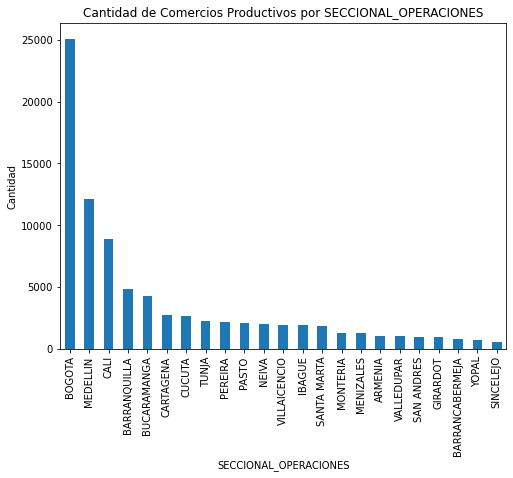

In [12]:
# Crear un gráfico de barras con etiquetas verticales en el eje x
plt.figure(figsize=(8, 6))
ax = conteo.plot(kind='bar', rot=0)
plt.title('Cantidad de Comercios Productivos por SECCIONAL_OPERACIONES')
plt.xlabel('SECCIONAL_OPERACIONES')
plt.ylabel('Cantidad')

# Agregar etiquetas verticales al eje x
plt.xticks(rotation=90)

plt.show()

Existen 23 seccionales a nivel nacional, para la gestión operativa de los comercios productivos: 
- La seccional con mayor volumen de comercios asociados corresponde a **Bogotá** con: 25.092 comercios (29.9%).
- La seccional con menor volumen de comercios asociados corresponde a **Sincelejo** con: 591 comercios (0.70%).
- Las 3 seccionales principales agrupan el 55% de los comercios: **Bogota, Medellin y Cali**.

In [13]:
#VARIABLES NUMERICAS

# Excluir la columna 'ID' de las estadísticas descriptivas
df_numericas = df.drop(columns=['ID'])

# Obtener el resumen estadístico (transpose) de las variables numéricas
df_numericas.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TERMINALES_VIGENTES,83937.0,2.207942,4.625107,1.00000,1.000000,1.000000,2.000000,446.000000
QR_ULT_MES,83937.0,0.185794,0.700365,0.00000,0.000000,0.000000,0.000000,26.000000
TRX_ULT_MES,83937.0,532.274384,1548.823112,1.00000,33.000000,119.000000,419.000000,75805.000000
REVERSOS_ULT_MES,83937.0,0.600295,2.119145,0.00000,0.000000,0.000000,0.000000,143.000000
TASA_REVERSOS_ULT_MES,83937.0,0.002099,0.015377,0.00000,0.000000,0.000000,0.000000,1.000000
TASA_NEGACIONES_ULT_MES,83937.0,0.077882,0.093913,0.00000,0.033333,0.057640,0.090909,1.000000
DIFERENCIA_TRX,83937.0,51.217270,295.095901,-9758.00000,-7.000000,5.000000,36.000000,17696.000000
VARIACION_TRX,83937.0,0.526204,9.782262,-0.99894,-0.092593,0.038674,0.222222,1616.333333
TASA_QR,83937.0,0.088930,0.326632,0.00000,0.000000,0.000000,0.000000,9.000000


En relación a las estadísticas descriptivas, para los comercios objeto de análisis:

- Tienen en promedio 2.2 **Terminales Vigentes** y máximo 446. El 25% de los comercios con mayor volumen, tienen más de 2 terminales. 
- En promedio radicaron 0.18 **Quejas o Reclamos** el ultimo mes, el que más QR registró tuvo 26. Al menos el 75% no radicó ninguna QR el último mes. 
- Los comercios realizaron en promedio 532.3 **Trx el último mes**, con std de 1548.8 lo que indica alta dispersión de los datos. El 25% de los comercios con mayor número de trx realizadas, registraron más de 419 trx. 
- El promedio del **Número de Reversos** por comercio en el último mes fue de 0.60. Al menos el 75% no tuvo ningún reverso. 
- La **Tasa de Reversos** promedio del último mes fue de 0.2099% con std de 1.54%. Al menos el 75% tiene tasa del 0%.
- La **Tasa de Negaciones** promedio del último mes fue de 7.8% con std de 9.4%. El 25% con mayor tasa están por encima de 9.9%.
- La **Diferencia de trx** realizadas en el último mes respecto al anterior, es en promedio de 51.21 trx adicionales, reflejando aumento transaccional. 
- La **Variación(%) de trx** realizadas en el último mes respecto al anterior, es en promedio de 52.6%, reflejando aumento transaccional. 
- La **Tasa de Quejas y Reclamos** promedio es de 8.89%. Al menos el 75% tiene tasa del 0%. La tasa máxima fue de 9, corresponde a un comercio que registró un número de QR que es 9 veces mayor a su número de terminales vigentes (Datáfonos). 

In [14]:
# Obtener una lista de las columnas numéricas, excluyendo la columna "ID"
variables_numericas = df.select_dtypes(include=['number']).drop(columns=['ID'])
columnas_numericas= variables_numericas.columns
columnas_numericas

Index(['TERMINALES_VIGENTES', 'QR_ULT_MES', 'TRX_ULT_MES', 'REVERSOS_ULT_MES',
       'TASA_REVERSOS_ULT_MES', 'TASA_NEGACIONES_ULT_MES', 'DIFERENCIA_TRX',
       'VARIACION_TRX', 'TASA_QR'],
      dtype='object')

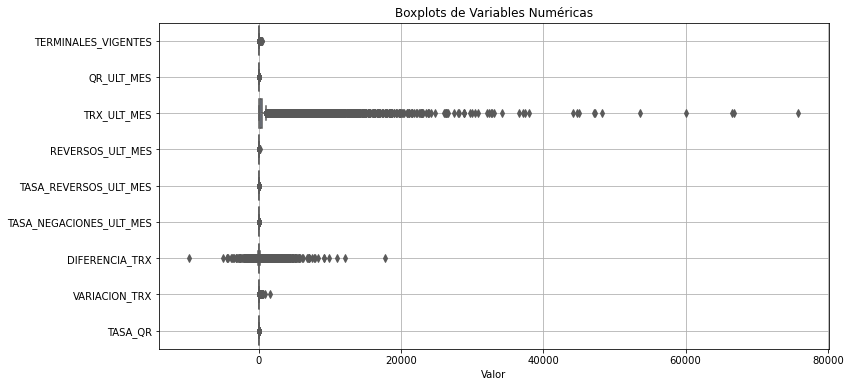

In [15]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crear boxplots para las variables numéricas
sns.boxplot(data=variables_numericas, orient="h", palette="Set2")

# Personalizar la gráfica
plt.title('Boxplots de Variables Numéricas')
plt.xlabel('Valor')
plt.grid(True)

# Mostrar la gráfica
plt.show()


En la gráfica anterior es posible identificar: 
- Las variables se encuentran en escalas de medida distintas. 
- Existe presencia de outliers o valores atipicos para las distintas variables. 


Gráficaremos a continuación los boxplot de forma individual para cada variable con y sin outliers: 

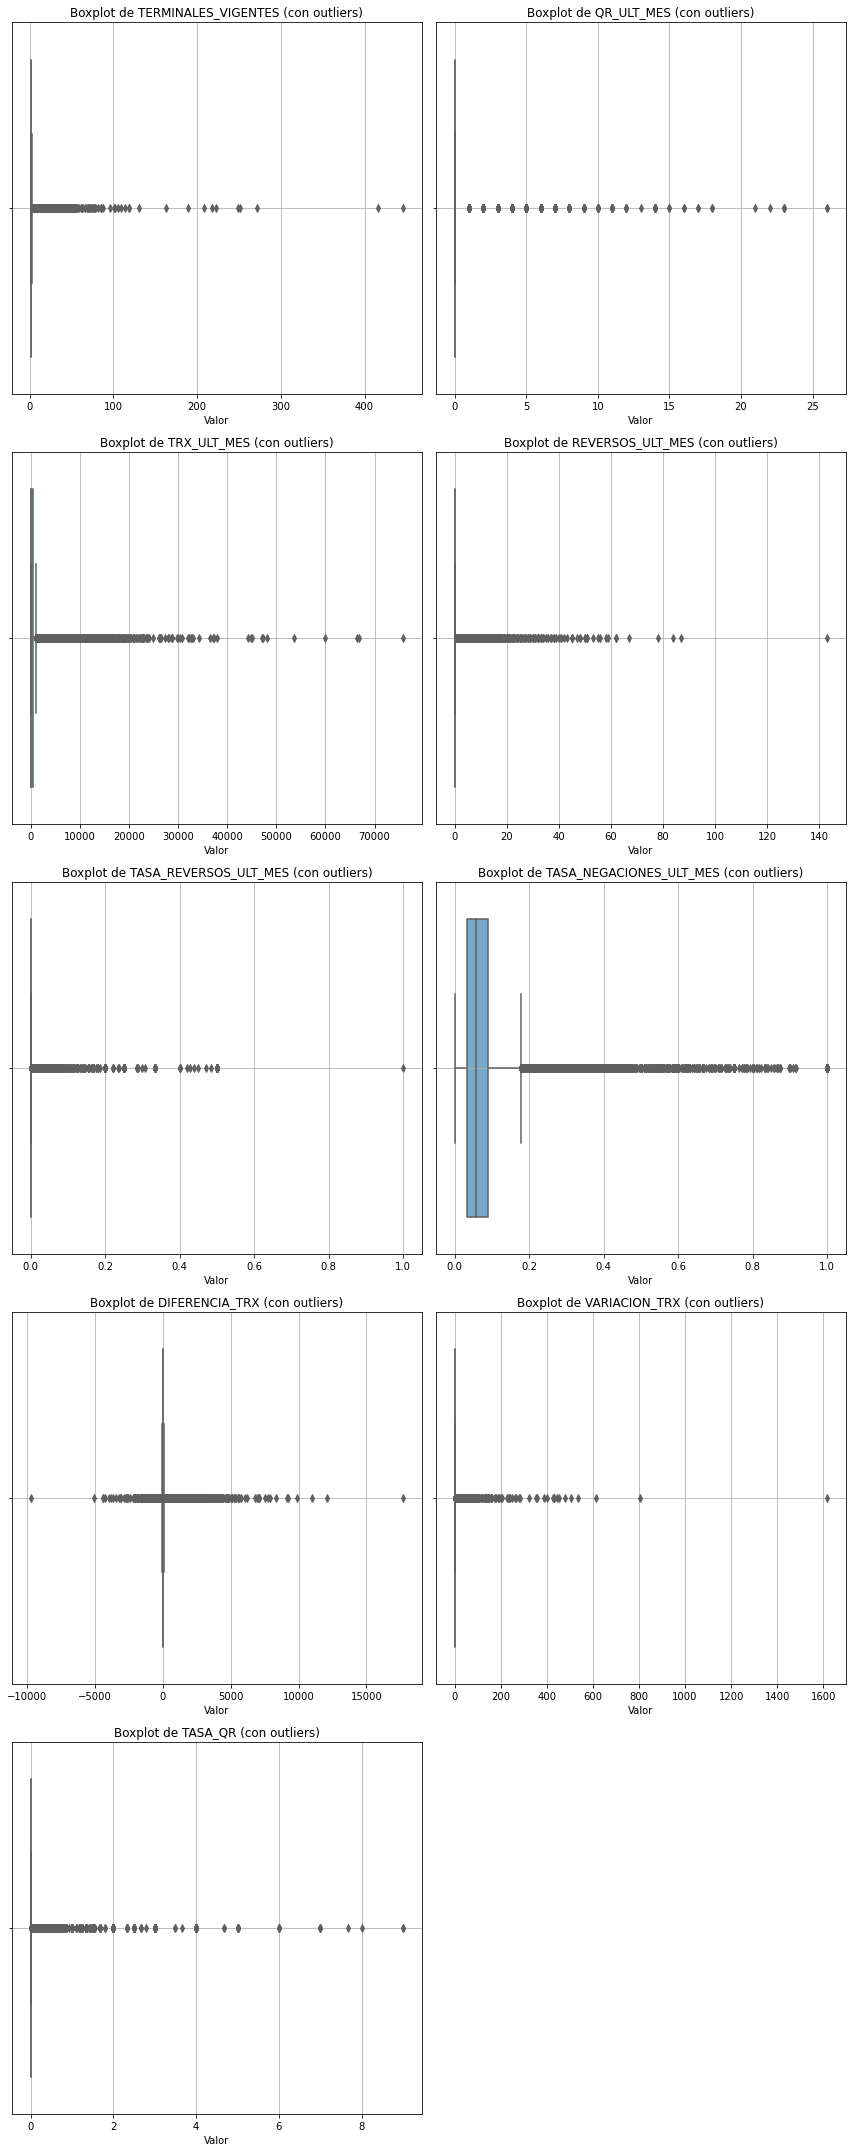

In [16]:
# Calcular el número de filas y columnas para organizar las gráficas
num_variables = len(columnas_numericas)
num_por_fila = 2
num_filas = math.ceil(num_variables / num_por_fila)

# Configurar el tamaño de las gráficas
plt.figure(figsize=(12, 6 * num_filas))

# Crear boxplots sin outliers para cada variable numérica en gráficas con 2 por fila
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(num_filas, num_por_fila, i)
    sns.boxplot(x=df[columna], orient="h", palette="Blues", showfliers=True)
    plt.title(f'Boxplot de {columna} (con outliers)')
    plt.xlabel('Valor')
    plt.grid(True)

# Ajustar el espaciado entre las gráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

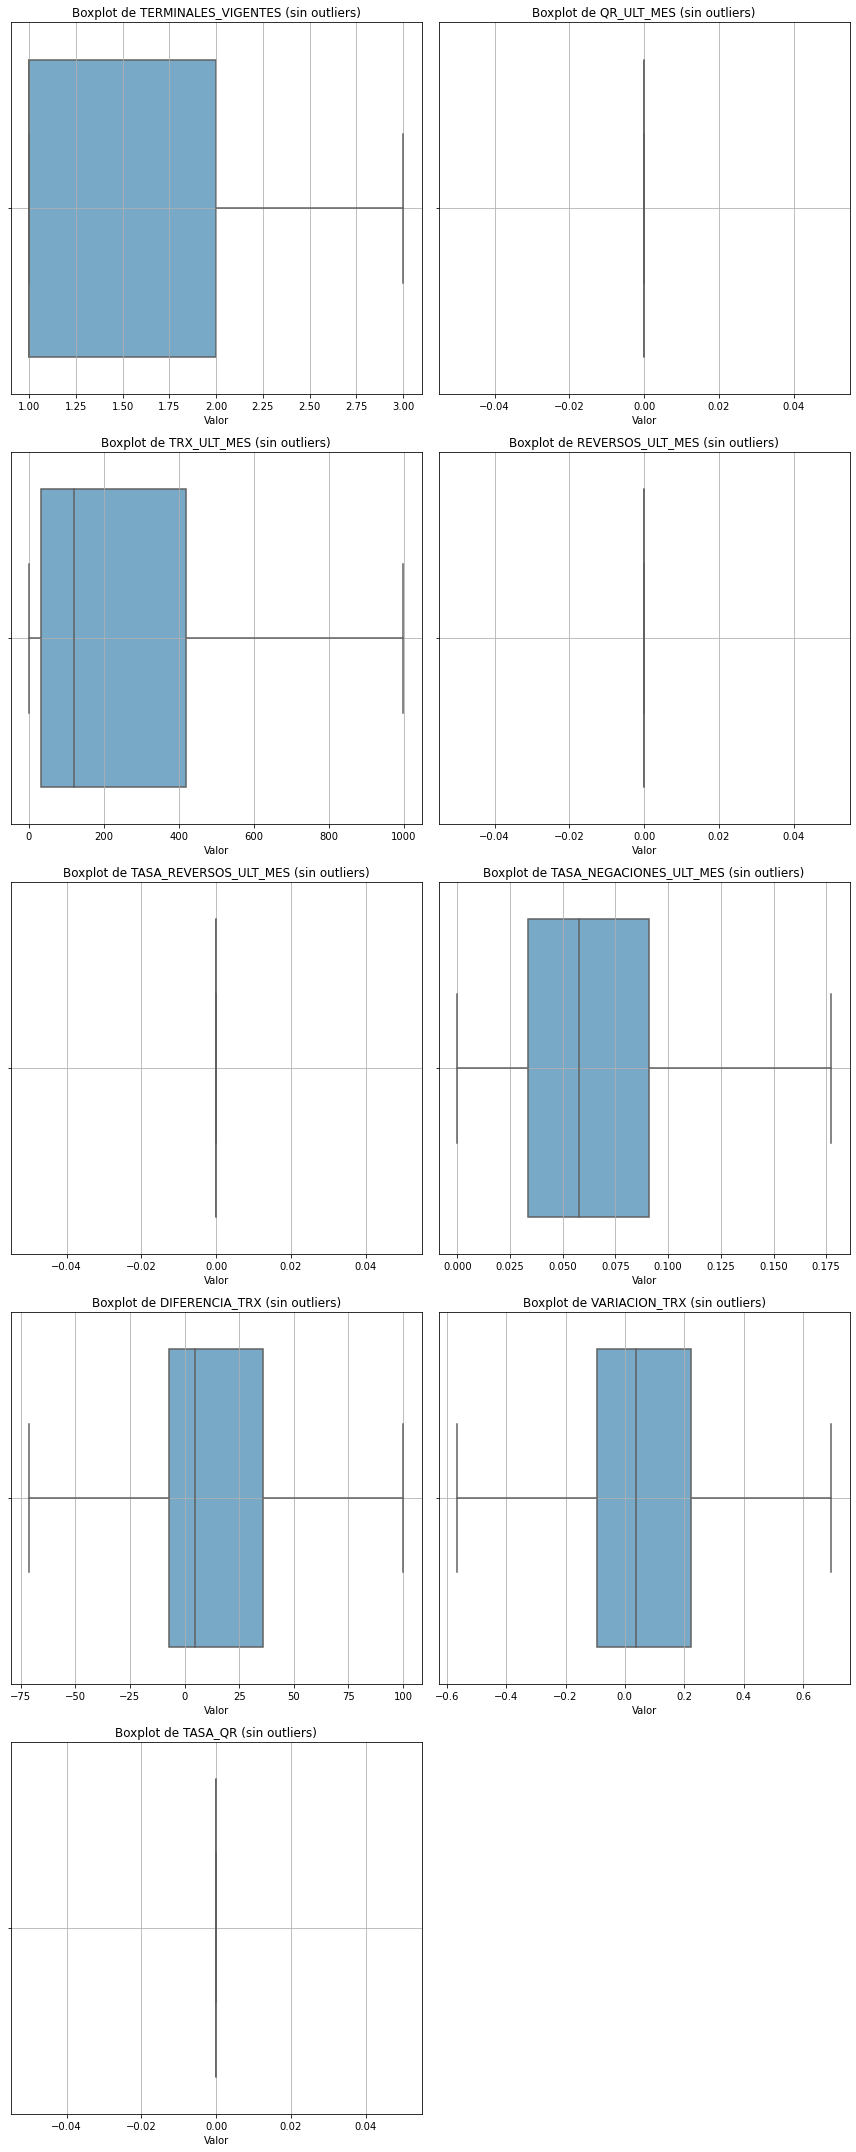

In [17]:
# Calcular el número de filas y columnas para organizar las gráficas
num_variables = len(columnas_numericas)
num_por_fila = 2
num_filas = math.ceil(num_variables / num_por_fila)

# Configurar el tamaño de las gráficas
plt.figure(figsize=(12, 6 * num_filas))

# Crear boxplots sin outliers para cada variable numérica en gráficas con 2 por fila
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(num_filas, num_por_fila, i)
    sns.boxplot(x=df[columna], orient="h", palette="Blues", showfliers=False)
    plt.title(f'Boxplot de {columna} (sin outliers)')
    plt.xlabel('Valor')
    plt.grid(True)

# Ajustar el espaciado entre las gráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()

In [18]:
df.columns

Index(['ID', 'SECCIONAL_OPERACIONES', 'TERMINALES_VIGENTES', 'QR_ULT_MES',
       'TRX_ULT_MES', 'REVERSOS_ULT_MES', 'TASA_REVERSOS_ULT_MES',
       'TASA_NEGACIONES_ULT_MES', 'DIFERENCIA_TRX', 'VARIACION_TRX',
       'TASA_QR'],
      dtype='object')

Bajo el contexto del negocio y para la identificación de las situaciones problemáticas potenciales para los comercios, es importante considerar lo siguiente:

**Comportamiento de Quejas y Reclamos:**
- Se espera que entre más terminales o datáfonos vigentes (TERMINALES_VIGENTES) tenga un comercio, el número de QR radicadas ("QR_ULT_MES") sea mayor dado que a más datafonos en uso, mayores daños potenciales. 
- Para evitar distorsiones originadas por el número de QR radicadas, se sugiere tomar para el análisis "TASA_QR" y descartar "QR_ULT_MES". 
- Lo deseable para el negocio es que la "TASA_QR" de sus comercios tienda a cero. 
- Una mayor "TASA_QR" sugiere una problemática en el comercio. 

**Comportamiento Transaccional:** 
- Para el negocio es deseable que los comercios presenten crecimiento transaccional. 
- Lo deseable es que DIFERENCIA_TRX sea positiva, lo que indica que el comercio realizó más trx el último mes respecto al anterior. 
-  'TRX_ULT_MES' indicará el potencial transaccional actual del comercio, los comercios de mayor número de trx son de mayor interés para el negocio. 

**Número y Tasa de Reversos:** 
- Un Reverso o transacción reversada se refiere a una acción en la que una transacción previamente autorizada o procesada se revierte o se cancela, lo que significa que los fondos que se habían transferido inicialmente se devuelven al titular de la cuenta o tarjeta. Esto puede suceder por varias razones dentro de las cuales se encuentran errores de procesamiento o de comunicación, entre otros.
- Aunque la tasa de reversos suele ser muy baja, cuando se presentan trx reversadas puede generar molestias para comercios y/o tarjetahabientes ya que en algunos casos la devolución de los fondos no se refleja automáticamente en la cuenta del tarjetahabiente y da lugar a discusiones, puesto que: Por un lado, el comercio ve la transacción reversada desde el datáfono (no recibe el pago), pero por otro lado, el tarjetahabiente ve el pago exitoso desde su cuenta o medio de pago y puede no recibir en línea la notificación del reverso de la trx. 
- Se espera que entre mayor  'TRX_ULT_MES' tenga un comercio, el valor de REVERSOS_ULT_MES sea mayor.
- Para evitar distorsiones originadas por "REVERSOS_ULT_MES", se sugiere tomar para el análisis "TASA_REVERSOS_ULT_MES" y descartar "REVERSOS_ULT_MES". 
- Lo deseable para el negocio es que la "TASA_REVERSOS_ULT_MES" de sus comercios tienda a cero. 
- Una mayor "TASA_REVERSOS_ULT_MES" sugiere una problemática en el comercio. 


**Tasa de Negaciones:** 
- Una transacción negada se refiere a una situación en la que una solicitud de pago o transacción es rechazada o denegada por la entidad o sistema de procesamiento de pagos (Autorizador) encargada de validarla. Esto significa que la transacción no se autoriza y por lo tanto, no se completa.
- Las transacciones pueden ser negadas por diversas razones, algunas de las situaciones más comunes son: Fondos insuficientes, Pin inválido, límite de crédito excedido, bloqueo de tarjeta, errores en la información de la tarjeta, restricciones de seguridad, tarjeta vencida, problemas técnicos en los sistemas de procesamiento de pagos o en los datáfonos, sospecha de fraude, restricciones de cuenta, entre otros. 
- El negocio busca maximizar su tasa de aprobaciones, o en otras palabras, minimizar su tasa de negaciones. Lo cual además de mejorar el servicio hacia sus clientes (comercios) y hacia los tarjetahabientes, también favorece los ingresos del negocio quien le cobra a los Bancos Emisores por las transacciones autorizadas, recibiendo un pago mayor por aquellas que son aprobadas respecto a las negadas.  
- Lo deseable para el negocio es que la "'TASA_NEGACIONES_ULT_MES" de sus comercios tienda a cero. 
- Una mayor "'TASA_NEGACIONES_ULT_MES" sugiere una problemática en el comercio. 


**Capacidad Operativa:** 

- Las variables 'SECCIONAL_OPERACIONES' y 'TERMINALES_VIGENTES' son variables a tener en cuenta para la articulación del plan de mantenimiento preventivo a gestionar por el negocio.
- Cada seccional fijará una capacidad mensual del número de terminales a gestionar, de acuerdo al personal técnico disponible para dicha actividad. 
- Para efectos prácticos, una vez seleccionados los comercios idoneos para inclusión en el Plan Nacional de Mantenimiento, cada Seccional se encargaría de validar aquellos que le corresponden para su gestión de acuerdo a dicha capacidad. 

Finalmente, se deberán escoger para inclusión dentro del plan de mantenimiento mensual, aquellos comercios que presenten situaciones problemáticas bajo los escenarios expuestos y que a su vez sean de interés para el negocio. Esto es, comercios con: 
- Disminución Transaccional
- Alta Tasa de Reversos
- Alta Tasa de Negaciones
- Alta Tasa Quejas y Reclamos
- Mayor potencial transaccional, dado el número de trx realizadas el último mes.
 

Por otro lado, se espera que las anteriores consideraciones contribuyan a lograr mayor interpretabilidad de los resultados para el negocio y constituyan criterios de decisión para la selección de los clústers de comercios a gestionar dentro de su plan de mantenimiento mensual.

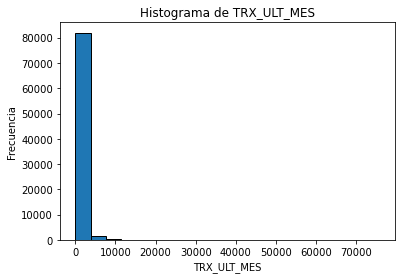

            Intervalo  Frecuencia
0        1.00-3791.20       81925
1     3791.20-7581.40        1421
2    7581.40-11371.60         315
3   11371.60-15161.80         133
4   15161.80-18952.00          63
5   18952.00-22742.20          31
6   22742.20-26532.40          17
7   26532.40-30322.60           9
8   30322.60-34112.80           7
9   34112.80-37903.00           4
10  37903.00-41693.20           1
11  41693.20-45483.40           3
12  45483.40-49273.60           3
13  49273.60-53063.80           0
14  53063.80-56854.00           1
15  56854.00-60644.20           1
16  60644.20-64434.40           0
17  64434.40-68224.60           2
18  68224.60-72014.80           0
19  72014.80-75805.00           1


In [19]:
data = df['TRX_ULT_MES']

# Definir el número de bins y calcular el histograma
num_bins = 20  # Puedes ajustar el número de bins según tu preferencia
hist, bin_edges = np.histogram(data, bins=num_bins)

# Crear un DataFrame con los resultados
tabla_frecuencia = pd.DataFrame({'Intervalo': [(f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}') for i in range(len(bin_edges)-1)],
                                 'Frecuencia': hist})

# Mostrar el histograma
plt.hist(data, bins=num_bins, edgecolor='black')
plt.xlabel('TRX_ULT_MES')
plt.ylabel('Frecuencia')
plt.title('Histograma de TRX_ULT_MES')
plt.show()

# Mostrar la tabla de frecuencia
print(tabla_frecuencia)

In [20]:
#Cálculo deciles según 'TRX_ULT_MES'
deciles = [df['TRX_ULT_MES'].quantile(q=i/10) for i in range(1, 10)]

# Añadir el mínimo y máximo
deciles = [df['TRX_ULT_MES'].min()] + deciles + [df['TRX_ULT_MES'].max()]

# Imprimir los deciles
print("Deciles de TRX_ULT_MES:")
for i, decil in enumerate(deciles):
    print(f"Decil {i}: {decil}")


Deciles de TRX_ULT_MES:
Decil 0: 1
Decil 1: 9.0
Decil 2: 24.0
Decil 3: 45.0
Decil 4: 74.0
Decil 5: 119.0
Decil 6: 190.0
Decil 7: 316.0
Decil 8: 574.0
Decil 9: 1276.0
Decil 10: 75805


In [21]:
#Para reducir el df dejando solo los comercios de mayor trx, pues arroja problema de memoria al usar todos los registros.
n=90
percentil_TRX_ULT_MES = np.percentile(df['TRX_ULT_MES'], n)
print(f'El percentil {n}% de TRX_ULT_MES es: {percentil_TRX_ULT_MES}')

El percentil 90% de TRX_ULT_MES es: 1276.0


In [22]:
# Filtrar el DataFrame para seleccionar solo los registros que cumplen con el criterio
df= df[df['TRX_ULT_MES'] > percentil_TRX_ULT_MES]

In [23]:
# Obtener el tamaño del DataFrame Final, luego de validaciones y depuración:
num_filas, num_columnas = df.shape
print(f'Número de filas: {num_filas}')
print(f'Número de columnas: {num_columnas}')

Número de filas: 8390
Número de columnas: 11


In [24]:
#Depuración de variables para algoritmos de Clustering:
columnas_a_eliminar = ['ID', 'QR_ULT_MES', 'REVERSOS_ULT_MES', 'SECCIONAL_OPERACIONES', 
                       'TERMINALES_VIGENTES', 'TRX_ULT_MES', 'DIFERENCIA_TRX']
df = df.drop(columnas_a_eliminar, axis=1)
df.columns

Index(['TASA_REVERSOS_ULT_MES', 'TASA_NEGACIONES_ULT_MES', 'VARIACION_TRX',
       'TASA_QR'],
      dtype='object')

In [25]:
# Obtener el tamaño del DataFrame Final, luego de validaciones y depuración:
num_filas, num_columnas = df.shape
print(f'Número de filas: {num_filas}')
print(f'Número de columnas: {num_columnas}')

Número de filas: 8390
Número de columnas: 4


In [26]:
df.head()

,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR
60,0.000000,0.030921,0.021536,0.000000
61,0.002608,0.035994,0.099828,0.000000
125,0.001517,0.044259,0.021970,0.142857
194,0.001395,0.043236,0.056743,0.000000
202,0.000444,0.138605,0.202457,0.000000


In [27]:
#escalar las variables de interés
X_scaled = StandardScaler().fit_transform(df)
print(X_scaled[:5])

[[-0.70019515 -1.19048678 -0.04521741 -0.41892171]
 [ 1.07932701 -0.97046155 -0.04182327 -0.41892171]
 [ 0.3351141  -0.61199375 -0.04519863  0.09865488]
 [ 0.25136524 -0.65637369 -0.04369112 -0.41892171]
 [-0.39709928  3.47984653 -0.03737403 -0.41892171]]


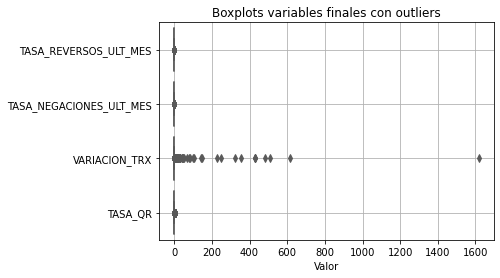

In [28]:
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))

# Crear boxplots para las variables numéricas
sns.boxplot(data=df, orient="h", palette="Set2")

# Personalizar la gráfica
plt.title('Boxplots variables finales con outliers')
plt.xlabel('Valor')
plt.grid(True)

# Mostrar la gráfica
plt.show()

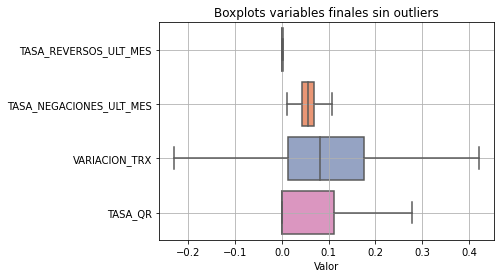

In [29]:
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 4))

# Crear boxplots para las variables numéricas
sns.boxplot(data=df, orient="h", palette="Set2", showfliers=False)

# Personalizar la gráfica
plt.title('Boxplots variables finales sin outliers')
plt.xlabel('Valor')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# CLUSTERING JERÁRQUICO

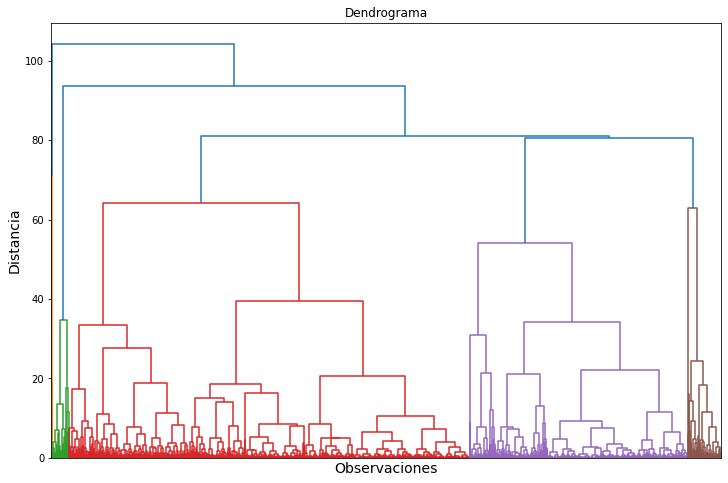

In [30]:
dist = pdist(X_scaled, metric='euclidean')
Z = linkage(dist, method='ward')

fig, ax = plt.subplots(figsize=(12, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)
ax.set_title('Dendrograma')
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
ax.set_xticks([])
plt.show()

Cantidad de clusters: 5


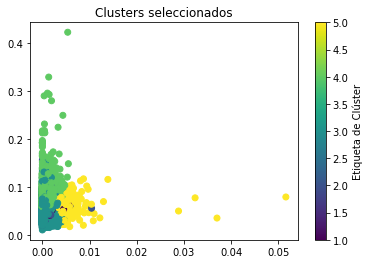

In [31]:
distancia_fijada=80 #probar cambiando este valor
clusters = fcluster(Z, distancia_fijada, criterion="distance")
num_clusters = len(np.unique(clusters))

print('Cantidad de clusters: ' +str(num_clusters))

plt.scatter(df.iloc[:,0], df.iloc[:,1], c=clusters,cmap='viridis')
plt.colorbar(label='Etiqueta de Clúster')
plt.title('Clusters seleccionados')
plt.show()

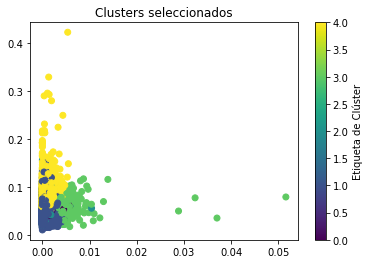

In [32]:
#ALGORITMO AGLOMERATIVO
cluster_sk = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster_sk =cluster_sk.fit_predict(X_scaled)

plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster_sk,cmap='viridis')
plt.colorbar(label='Etiqueta de Clúster')
plt.title('Clusters seleccionados')
plt.show()


In [33]:
df['Cluster_Jerarquico'] = cluster_sk

# Supongamos que deseas contar los registros en cada categoría de la columna 'Categoria' de tu DataFrame df
Clusters_Jerarquico_counts = df['Cluster_Jerarquico'].value_counts()

# Imprimir la cuenta de registros en cada categoría
print(Clusters_Jerarquico_counts)

1    5026
4    2736
3     408
2     209
0      11
Name: Cluster_Jerarquico, dtype: int64


In [34]:
print("CLUSTERING JERARQUICO:")
print("Comercios en clusters de interés: ", 408+209+11)
print("Partcipación(%) respecto al total de comercios de interés: ", round((408+209+11)/8390,4))

CLUSTERING JERARQUICO:
Comercios en clusters de interés:  628
Partcipación(%) respecto al total de comercios de interés:  0.0749


In [35]:
# Filtrar el DataFrame para incluir solo los registros donde 'Cluster_Jerarquico' es 0, 2 o 3
filtered_df = df[df['Cluster_Jerarquico'].isin([0, 2, 3])]

# Calcular el describe() para los registros filtrados
result = filtered_df.groupby(by='Cluster_Jerarquico').describe().T

# Imprimir el resumen de estadísticas descriptivas
print('Descripción de los grupos:')
print(result)


Descripción de los grupos:
Cluster_Jerarquico                       0           2           3
TASA_REVERSOS_ULT_MES   count    11.000000  209.000000  408.000000
                        mean      0.001977    0.000969    0.005070
                        std       0.001845    0.001158    0.003721
                        min       0.000000    0.000000    0.002673
                        25%       0.000498    0.000259    0.003605
                        50%       0.001817    0.000664    0.004348
                        75%       0.002509    0.001362    0.005443
                        max       0.005790    0.010417    0.051569
TASA_NEGACIONES_ULT_MES count    11.000000  209.000000  408.000000
                        mean      0.056415    0.055300    0.060981
                        std       0.017998    0.019173    0.016131
                        min       0.035373    0.017574    0.016742
                        25%       0.044002    0.042155    0.049280
                        50%       0

Interpretación Clusters obtenidos aplicando CLUSTER JERÁRQUICO:

- **Cluster 0:** 11 comercios con alta variacion trx, pueden ser comercios nuevos que aumentaron significativamente sus trx del mes anterior al ultimo mes.  
- **Cluster 2:** 209 comercios con alta tasa de quejas y reclamos en el ultimo mes.
- **Cluster 3:** 408 Comercios con alta tasa de reversos alta en el último mes. 

Los cluster 0, 2 y 3 representan comercios de interés para inclusión dentro del plan de mantenimiento de la red de datáfonos: 
- Para el **cluster 0**  dado que son establecimientos con alta variación transaccional respecto al mes anterior, en el plan de mantenimiento se pueden descartar novedades con los datafonos y fidelizar al comercio en busca de mantener el crecimiento transaccional.  
- Para los **cluster 2 y 3** que representan comercios con problemáticas potenciales (Alta tasa de reversos o alta tasa de quejas reclamos), en el plan de mantenimiento se pueden corregir novedades con los datafonos o su parametrización en busca de disminuir estas tasas. 

In [36]:
#CLUSTER 0
#Comercios con alta variacion transaccional en el último mes respecto al anterior

print ("Cluster Jerarquico: 0")
Cluster_Jerarquico0 = df[df['Cluster_Jerarquico'] == 0]
Cluster_Jerarquico0.head(15)

Cluster Jerarquico: 0


,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico
49841,0.000000,0.062362,226.166667,0.250000,0
54382,0.000217,0.035373,248.081081,0.142857,0
66376,0.001889,0.091785,352.000000,0.200000,0
72034,0.000779,0.052181,320.000000,0.000000,0
75061,0.002957,0.042811,506.214286,0.250000,0
94379,0.001817,0.085929,427.000000,0.000000,0
119592,0.000101,0.045193,430.000000,0.125000,0
121363,0.005790,0.060220,430.750000,0.250000,0
131195,0.002061,0.051319,1616.333333,0.000000,0
134926,0.004508,0.053051,479.666667,0.000000,0


In [37]:
#CLUSTER 2
#Comercios con alta tasa de quejas y reclamos en el último mes

print ("Cluster Jerarquico: 2")
Cluster_Jerarquico2 = df[df['Cluster_Jerarquico'] == 2]
Cluster_Jerarquico2.head(15)

Cluster Jerarquico: 2


,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico
1751,0.000000,0.155814,0.045593,2.000000,2
5210,0.000390,0.035840,0.128848,1.666667,2
6606,0.000203,0.024301,-0.054566,1.333333,2
7308,0.000266,0.046858,0.123206,1.000000,2
10682,0.001333,0.042000,0.015572,1.000000,2
11201,0.001326,0.073796,0.268498,1.000000,2
11796,0.001278,0.048999,0.052939,1.200000,2
13994,0.000000,0.038309,0.001985,1.000000,2
18577,0.001325,0.039099,-0.021401,1.333333,2
22514,0.000311,0.076564,0.104124,1.000000,2


In [38]:
#CLUSTER 3
#comercios con alta tasa de reversos en el último mes


print ("Cluster Jerarquico: 3")
Cluster_Jerarquico3 = df[df['Cluster_Jerarquico'] == 3]
Cluster_Jerarquico3.head(15)

Cluster Jerarquico: 3


,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico
568,0.003737,0.050862,0.051288,0.000000,3
848,0.003211,0.048812,0.827465,0.000000,3
897,0.003663,0.055678,0.047583,0.000000,3
1274,0.002796,0.070829,1.083495,0.000000,3
1281,0.004630,0.053819,0.046638,0.000000,3
1430,0.005929,0.063900,0.033356,0.333333,3
1697,0.006331,0.037987,0.120194,0.000000,3
2405,0.005324,0.026137,-0.032772,0.000000,3
2980,0.004972,0.031250,0.294118,0.000000,3
3149,0.003506,0.037398,0.096072,0.666667,3


In [39]:
df.head()

,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico
60,0.000000,0.030921,0.021536,0.000000,1
61,0.002608,0.035994,0.099828,0.000000,1
125,0.001517,0.044259,0.021970,0.142857,1
194,0.001395,0.043236,0.056743,0.000000,1
202,0.000444,0.138605,0.202457,0.000000,4


# CLUSTERING DBSCAN

In [40]:
selected_columns = ['TASA_REVERSOS_ULT_MES', 'TASA_NEGACIONES_ULT_MES', 'VARIACION_TRX', 'TASA_QR']
X=df[selected_columns]

In [41]:
# Definir los valores de eps que deseas probar
eps_values = [0.25, 0.5, 0.75, 1]

# Bucle para probar diferentes valores de eps
for epsilon in eps_values:
    min_samples = X_scaled.shape[1] * 2  # Número mínimo de muestras en una vecindad para formar un núcleo
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(X_scaled)
    
    # Agregar las etiquetas de clúster al DataFrame original para el valor de eps seleccionado
    df['Cluster_DBSCAN1'] = labels
    
    # Imprimir la cantidad de clústeres y la asignación de clústeres para el valor de eps seleccionado
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'Número de clústeres para eps={epsilon}: {num_clusters}')
    print(df.groupby('Cluster_DBSCAN1').size())  # Muestra la cantidad de registros en cada clúster


Número de clústeres para eps=0.25: 6
Cluster_DBSCAN1
-1     898
 0    7339
 1      71
 2      57
 3       8
 4       7
 5      10
dtype: int64
Número de clústeres para eps=0.5: 4
Cluster_DBSCAN1
-1     255
 0    7999
 1     112
 2      10
 3      14
dtype: int64
Número de clústeres para eps=0.75: 3
Cluster_DBSCAN1
-1     129
 0    8247
 1       8
 2       6
dtype: int64
Número de clústeres para eps=1: 2
Cluster_DBSCAN1
-1      75
 0    8294
 1      21
dtype: int64


In [42]:
# Valor fijo de eps
epsilon = 0.5

# Definir los valores de min_samples que deseas probar
min_samples_values = [int((X_scaled.shape[1] * 2) // 2), int(X_scaled.shape[1] * 2), int((X_scaled.shape[1] * 2) * 2)]

# Bucle para probar diferentes valores de min_samples con eps fijo en 0.5
for min_samples in min_samples_values:
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    # Agregar las etiquetas de clúster al DataFrame original
    df['Cluster_DBSCAN2'] = labels
    
    # Imprimir el valor de eps y min_samples, así como la cantidad de clústeres y la asignación de clústeres
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'eps={epsilon}, min_samples={min_samples}, Número de clústeres: {num_clusters}')
    print(df.groupby('Cluster_DBSCAN2').size())  # Muestra la cantidad de registros en cada clúster


eps=0.5, min_samples=4, Número de clústeres: 6
Cluster_DBSCAN2
-1     189
 0    8142
 1       7
 2       6
 3      33
 4       8
 5       5
dtype: int64
eps=0.5, min_samples=8, Número de clústeres: 4
Cluster_DBSCAN2
-1     255
 0    7999
 1     112
 2      10
 3      14
dtype: int64
eps=0.5, min_samples=16, Número de clústeres: 2
Cluster_DBSCAN2
-1     385
 0    7903
 1     102
dtype: int64


In [43]:
# Valores fijos de epsilon y min_samples
epsilon = 0.5
min_samples = 8

# Crear y ajustar el modelo DBSCAN con los valores fijos
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(X_scaled)

# Agregar las etiquetas de clúster al DataFrame original
df['Cluster_DBSCAN_Final'] = labels

# Imprimir la cantidad de clústeres y la asignación de clústeres
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'eps={epsilon}, min_samples={min_samples}, Número de clústeres: {num_clusters}')
print(df.groupby('Cluster_DBSCAN_Final').size())  # Muestra la cantidad de registros en cada clúster


eps=0.5, min_samples=8, Número de clústeres: 4
Cluster_DBSCAN_Final
-1     255
 0    7999
 1     112
 2      10
 3      14
dtype: int64


In [44]:
print("CLUSTERING DBSCAN:")
print("Comercios en clusterS de interés: ", 255+112+10+14)
print("Partcipación(%) respecto al total de comercios de interés: ", round((255+112+10+14)/8390,4))

CLUSTERING DBSCAN:
Comercios en clusterS de interés:  391
Partcipación(%) respecto al total de comercios de interés:  0.0466


In [45]:
112+10+14

136

In [46]:
df.head()

,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico,Cluster_DBSCAN1,Cluster_DBSCAN2,Cluster_DBSCAN_Final
60,0.000000,0.030921,0.021536,0.000000,1,0,0,0
61,0.002608,0.035994,0.099828,0.000000,1,0,0,0
125,0.001517,0.044259,0.021970,0.142857,1,0,0,0
194,0.001395,0.043236,0.056743,0.000000,1,0,0,0
202,0.000444,0.138605,0.202457,0.000000,4,0,0,0


In [47]:
df.columns

Index(['TASA_REVERSOS_ULT_MES', 'TASA_NEGACIONES_ULT_MES', 'VARIACION_TRX',
       'TASA_QR', 'Cluster_Jerarquico', 'Cluster_DBSCAN1', 'Cluster_DBSCAN2',
       'Cluster_DBSCAN_Final'],
      dtype='object')

In [48]:
columnas_a_borrar = ['Cluster_DBSCAN1', 'Cluster_DBSCAN2']
df = df.drop(columnas_a_borrar, axis=1)

In [49]:
df.head()

,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico,Cluster_DBSCAN_Final
60,0.000000,0.030921,0.021536,0.000000,1,0
61,0.002608,0.035994,0.099828,0.000000,1,0
125,0.001517,0.044259,0.021970,0.142857,1,0
194,0.001395,0.043236,0.056743,0.000000,1,0
202,0.000444,0.138605,0.202457,0.000000,4,0


In [50]:
selected_columns = ['TASA_REVERSOS_ULT_MES', 'TASA_NEGACIONES_ULT_MES', 'VARIACION_TRX', 'TASA_QR', 'Cluster_DBSCAN_Final']
X=df[selected_columns]

# Filtrar el DataFrame para incluir solo los registros donde 'Cluster_DBSCAN3' es -1, 1, 2 o 3
filtered_df2 = X[X['Cluster_DBSCAN_Final'].isin([-1, 1, 2, 3])]

# Calcular el describe() para los registros filtrados
result2 = filtered_df2.groupby(by='Cluster_DBSCAN_Final').describe().T

# Imprimir el resumen de estadísticas descriptivas
print('Descripción de los grupos:')
print(result2)


Descripción de los grupos:
Cluster_DBSCAN_Final                    -1           1          2          3
TASA_REVERSOS_ULT_MES   count   255.000000  112.000000  10.000000  14.000000
                        mean      0.003509    0.000687   0.000546   0.000430
                        std       0.005260    0.000654   0.000240   0.000213
                        min       0.000000    0.000000   0.000000   0.000000
                        25%       0.000707    0.000000   0.000419   0.000294
                        50%       0.002128    0.000528   0.000604   0.000508
                        75%       0.004632    0.001264   0.000726   0.000556
                        max       0.051569    0.002387   0.000762   0.000772
TASA_NEGACIONES_ULT_MES count   255.000000  112.000000  10.000000  14.000000
                        mean      0.087237    0.051848   0.040529   0.048009
                        std       0.057761    0.015959   0.006672   0.007071
                        min       0.016742    0.0

Interpretación Clusters obtenidos aplicando CLUSTER DBSCAN:

- **Cluster -1:** 255 Comercios con tasa de reversos promedio (0.35%) por encima del general (0.21%), tasa de negaciones promedio (8.7%) por encima del general (7.8%), variación transaccional promedio respecto al mes anterior de 27 (con alta desviación estandar 129.7) y alta tasa de quejas  reclamos promedio (77.9%).
- **Cluster 1:** 112 comercios con tasa de reversos y negaciones por debajo del promedio, variación transaccional promedio respecto al mes anterior de 26.3%, tasa de quejas o reclamos cercana al 100% (el numero de quejas/reclamos reportados es aproximandamente igual al numero de datafonos del comercio)
- **Cluster 2:** 10 comercios con tasa de reversos y negaciones por debajo del promedio, variación transaccional promedio respecto al mes anterior de 9.3%, tasa de quejas o reclamos promedio de 150% (el numero de quejas/reclamos reportados es significativamente mayor al numero de datafonos del comercio)
- **Cluster 3:** 14 comercios con tasa de reversos y negaciones por debajo del promedio, variación transaccional promedio respecto al mes anterior de 39%, tasa de quejas o reclamos promedio de 130% (el numero de quejas/reclamos reportados es mayor al numero de datafonos del comercio)

Estos cluster representan comercios de interés para inclusión dentro del plan de mantenimiento de la red de datáfonos: 
- Los **cluster 1, 2, 3** logran capturar comercios con tasa de quejas o reclamos cercana o mayor al 100%, esto es: el número de quejas o reclamos radicados el último mes iguala o supera el número de datafonos instalados en el comercio.
- El **Cluster -1** que identifica los outliers logra capturar comercios con varias situaciones de interés combinadas: tasa de reversos y negaciones promedio por encima de la tasa general, alta tasa de quejas y reclamos (promedio de 77.9%) y/o alta variación transaccional.

In [51]:
#CLUSTER -1

print ("Cluster DBSCAN: -1")
Cluster_DBSCAN_menos1 = df[df['Cluster_DBSCAN_Final'] == -1]
Cluster_DBSCAN_menos1.head(20)

Cluster DBSCAN: -1


,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico,Cluster_DBSCAN_Final
289,0.001456,0.085153,0.180412,0.750000,1,-1
1430,0.005929,0.063900,0.033356,0.333333,3,-1
1751,0.000000,0.155814,0.045593,2.000000,2,-1
3149,0.003506,0.037398,0.096072,0.666667,3,-1
3199,0.001434,0.292473,1.667304,0.000000,4,-1
5210,0.000390,0.035840,0.128848,1.666667,2,-1
6294,0.007590,0.056293,-0.137009,0.222222,3,-1
6606,0.000203,0.024301,-0.054566,1.333333,2,-1
7908,0.006263,0.103862,0.086784,0.083333,3,-1
8182,0.004392,0.051977,21.766667,1.000000,3,-1


In [52]:
#CLUSTER 1

print ("Cluster DBSCAN: 1")
Cluster_DBSCAN1 = df[df['Cluster_DBSCAN_Final'] == 1]
Cluster_DBSCAN1.head(15)

Cluster DBSCAN: 1


,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico,Cluster_DBSCAN_Final
7308,0.000266,0.046858,0.123206,1.0,2,1
10682,0.001333,0.042000,0.015572,1.0,2,1
11201,0.001326,0.073796,0.268498,1.0,2,1
11796,0.001278,0.048999,0.052939,1.2,2,1
13994,0.000000,0.038309,0.001985,1.0,2,1
22514,0.000311,0.076564,0.104124,1.0,2,1
25126,0.001037,0.053641,-0.147182,1.0,2,1
25138,0.001414,0.047859,-0.239324,1.0,2,1
26362,0.001368,0.038646,-0.056470,1.0,2,1
27781,0.000782,0.071205,0.000000,1.0,2,1


In [53]:
#CLUSTER 2

print ("Cluster DBSCAN: 2")
Cluster_DBSCAN2 = df[df['Cluster_DBSCAN_Final'] == 2]
Cluster_DBSCAN2.head(15)

Cluster DBSCAN: 2


,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico,Cluster_DBSCAN_Final
27509,0.000560,0.034135,0.128157,1.5,2,2
40383,0.000717,0.036559,-0.077381,1.5,2,2
48168,0.000648,0.036293,-0.020939,1.5,2,2
70998,0.000369,0.045611,0.132238,1.5,2,2
71930,0.000557,0.041337,0.145793,1.5,2,2
74777,0.000729,0.028780,0.009562,1.5,2,2
119498,0.000745,0.043964,0.609113,1.5,2,2
119678,0.000762,0.049505,0.138768,1.5,2,2
124519,0.000373,0.048844,-0.315117,1.5,2,2
125086,0.000000,0.040262,0.188254,1.5,2,2


In [54]:
#CLUSTER 3

print ("Cluster DBSCAN: 3")
Cluster_DBSCAN3 = df[df['Cluster_DBSCAN_Final'] == 3]
Cluster_DBSCAN3.head(15)

Cluster DBSCAN: 3


,TASA_REVERSOS_ULT_MES,TASA_NEGACIONES_ULT_MES,VARIACION_TRX,TASA_QR,Cluster_Jerarquico,Cluster_DBSCAN_Final
49744,0.000540,0.037724,0.055197,1.333333,2,3
49911,0.000288,0.054357,0.053636,1.333333,2,3
50071,0.000772,0.053444,0.013889,1.250000,2,3
50248,0.000628,0.043205,0.054570,1.200000,2,3
50717,0.000496,0.046041,-0.021137,1.250000,2,3
50971,0.000312,0.045852,0.062293,1.250000,2,3
65284,0.000561,0.051627,0.127135,1.200000,2,3
98288,0.000360,0.041382,-0.094788,1.333333,2,3
124059,0.000638,0.036352,0.053056,1.333333,2,3
125497,0.000233,0.043768,0.036661,1.333333,2,3


Cluster_DBSCAN_Final  -1     0    1   2   3
Cluster_Jerarquico                         
0                     11     0    0   0   0
1                     46  4974    6   0   0
2                     78     1  106  10  14
3                     69   339    0   0   0
4                     51  2685    0   0   0


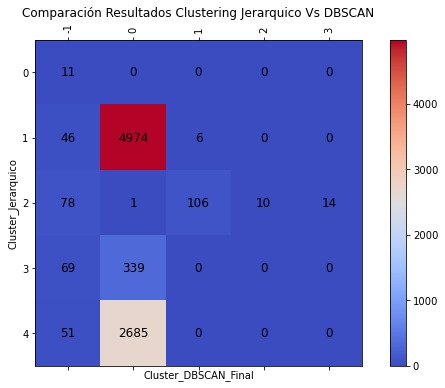

In [55]:
tabla_frecuencias = pd.crosstab(df['Cluster_Jerarquico'], df['Cluster_DBSCAN_Final'], normalize=False)

# Visualizar la tabla de frecuencias
print(tabla_frecuencias)

# Crear una representación gráfica de la tabla (opcional)
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(tabla_frecuencias, cmap='coolwarm')
fig.colorbar(cax)

# Añadir etiquetas a los ejes
plt.xticks(range(len(tabla_frecuencias.columns)), tabla_frecuencias.columns, rotation=90)
plt.yticks(range(len(tabla_frecuencias.index)), tabla_frecuencias.index)

# Añadir los valores de las frecuencias en cada celda
for i in range(len(tabla_frecuencias.index)):
    for j in range(len(tabla_frecuencias.columns)):
        ax.text(j, i, f'{tabla_frecuencias.iloc[i, j]}', ha='center', va='center', color='black', fontsize=12)

plt.xlabel('Cluster_DBSCAN_Final')
plt.ylabel('Cluster_Jerarquico')
plt.title('Comparación Resultados Clustering Jerarquico Vs DBSCAN')
plt.show()



Cluster_DBSCAN_Final        -1          0         1        2         3
Cluster_Jerarquico                                                    
0                     0.131108   0.000000  0.000000  0.00000  0.000000
1                     0.548272  59.284863  0.071514  0.00000  0.000000
2                     0.929678   0.011919  1.263409  0.11919  0.166865
3                     0.822408   4.040524  0.000000  0.00000  0.000000
4                     0.607867  32.002384  0.000000  0.00000  0.000000


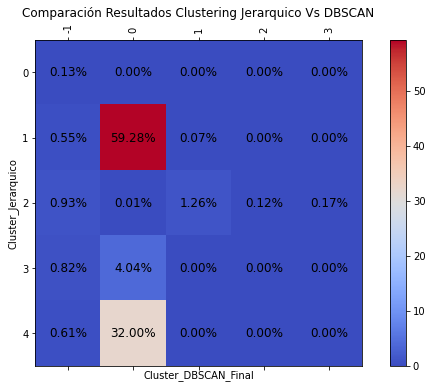

In [56]:
tabla_frecuencias = pd.crosstab(df['Cluster_Jerarquico'], df['Cluster_DBSCAN_Final'], normalize='all') * 100

# Visualizar la tabla de frecuencias con porcentajes
print(tabla_frecuencias)

# Crear una representación gráfica de la tabla (opcional)
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(tabla_frecuencias, cmap='coolwarm')
fig.colorbar(cax)

# Añadir etiquetas a los ejes
plt.xticks(range(len(tabla_frecuencias.columns)), tabla_frecuencias.columns, rotation=90)
plt.yticks(range(len(tabla_frecuencias.index)), tabla_frecuencias.index)

# Añadir los valores de los porcentajes en cada celda
for i in range(len(tabla_frecuencias.index)):
    for j in range(len(tabla_frecuencias.columns)):
        ax.text(j, i, f'{tabla_frecuencias.iloc[i, j]:.2f}%', ha='center', va='center', color='black', fontsize=12)

plt.xlabel('Cluster_DBSCAN_Final')
plt.ylabel('Cluster_Jerarquico')
plt.title('Comparación Resultados Clustering Jerarquico Vs DBSCAN')
plt.show()


In [57]:
df.columns

Index(['TASA_REVERSOS_ULT_MES', 'TASA_NEGACIONES_ULT_MES', 'VARIACION_TRX',
       'TASA_QR', 'Cluster_Jerarquico', 'Cluster_DBSCAN_Final'],
      dtype='object')

In [58]:
# Exportar el df a un archivo CSV
nombre_archivo_csv = 'Clustering_Comercios_Red_Datafonos.csv'
df.to_csv(nombre_archivo_csv) 

# Obtener la ruta absoluta del archivo CSV
ruta_absoluta = os.path.abspath(nombre_archivo_csv)

# Imprimir la ruta absoluta
print(f'Ruta absoluta del archivo: {ruta_absoluta}')

Ruta absoluta del archivo: C:\Users\Laura\APRENDIZAJE NO SUPERVISADO\Clustering_Comercios_Red_Datafonos.csv
